<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive/S11-Assignment/')
!ls /content/gdrive/My\ Drive/S11-Assignment

data		    eval.py	  misclassified.py  README.md	     utils.py
dataloader.py	    grad_cam.py   Models	    S10-GradCam.pdf
Data_Transforms     __init__.py   one_cycle.py	    S10-graph.png
data_transforms.py  lr_finder.py  __pycache__	    S10.ipynb


In [3]:
%cd /content/gdrive/My Drive/S11-Assignment/

/content/gdrive/My Drive/S11-Assignment


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
!pip install albumentations

     |████████████████████████████████| 634kB 1.4MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=4d82944d329a2b2b1119fe2b4879e5584cdaac7e6b789ecdb6e360e4669592fd
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [5]:
cd /content/gdrive/My Drive/S11-Assignment/

/content/gdrive/My Drive/S11-Assignment


In [6]:
from Data_Transforms import transform

import importlib
importlib.reload(transform)

#from transform  import Data
data = transform.Data()

trainset = data.getTrainDataSetTorchTransforms(train=True)
testset =  data.getTestDataSetTorchTransforms(train=False)
trainloader = data.getDataLoader(trainset, 512)
show_trainloader = data.getDataLoader(trainset, 4)
testloader = data.getDataLoader(testset, 512)
show_testloader = data.getDataLoader(testset, 4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


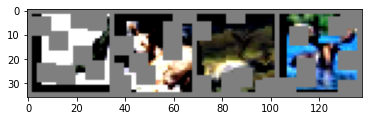

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import utils

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
utils.imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:

import torch
from Models import customresnet
!pip install torchsummary
from torchsummary import summary

model = customresnet.CustomResNet()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(model.device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


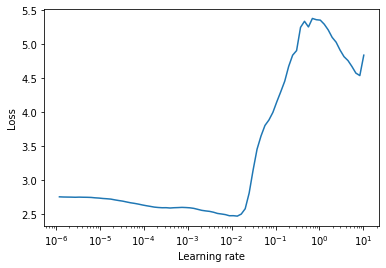

In [9]:
from lr_finder import LRFinder

import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import StepLR


EPOCHS = 24
l2_loss = 0.0001
l1_lambda = 0
criterion = nn.CrossEntropyLoss()

#Optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=l2_loss)

#LR Finder
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

We'll use method described in paper : https://arxiv.org/abs/1506.01186 to find out optimum learning rate.
We'll increase the learning rate from lower value per iteration for some iterations till loss starts exploding.
We'll plot loss vs learning rate plot.
We'll then select learning rate that is one power higher than the one where loss is minimum
This value can be used as maximum value in Cyclic Learning Rate policy and minimum learning rate
can be set to 1/3, 1/4th of max value.



In [10]:
#Find the min loss from lr finder
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
print(min(loss))
print(lr[loss.index(min(loss))])


2.467934122212347
0.013489628825916521


In [0]:
LRMAX = 0.1
LRMIN = 0.01

In [12]:
import one_cycle as OneCycle
from torch.optim.lr_scheduler import ReduceLROnPlateau

onecycle = OneCycle.OneCycle(int(len(trainset) * EPOCHS / 512), LRMAX, prcnt=60, momentum_vals=(0.95, 0.8))

optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=l2_loss)

# ReduceLROnPlateau
#schedular = ReduceLROnPlateau(optimizer, min_lr=1e-7, patience = 4)
schedular = None
model.evaluate(optimizer, trainloader, testloader, EPOCHS, criterion, onecycle, schedular, False, l1_lambda)

Epoch= 0 Loss=2.315014362335205 Batch_id=97 Accuracy=18.75: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 0, Train Accuracy: 18.75 , Test Accuracy: 18.44


Epoch= 1 Loss=2.0020625591278076 Batch_id=97 Accuracy=26.19: 100%|██████████| 98/98 [00:59<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1, Train Accuracy: 26.19047619047619 , Test Accuracy: 29.98


Epoch= 2 Loss=1.9304598569869995 Batch_id=97 Accuracy=38.39: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2, Train Accuracy: 38.392857142857146 , Test Accuracy: 39.7


Epoch= 3 Loss=1.8212165832519531 Batch_id=97 Accuracy=43.45: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3, Train Accuracy: 43.45238095238095 , Test Accuracy: 46.88


Epoch= 4 Loss=1.5557465553283691 Batch_id=97 Accuracy=53.57: 100%|██████████| 98/98 [01:00<00:00,  1.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4, Train Accuracy: 53.57142857142857 , Test Accuracy: 53.52


Epoch= 5 Loss=1.435534119606018 Batch_id=97 Accuracy=57.44: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5, Train Accuracy: 57.44047619047619 , Test Accuracy: 54.53


Epoch= 6 Loss=1.3145222663879395 Batch_id=97 Accuracy=56.55: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6, Train Accuracy: 56.54761904761905 , Test Accuracy: 58.66


Epoch= 7 Loss=1.1035951375961304 Batch_id=97 Accuracy=61.61: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7, Train Accuracy: 61.607142857142854 , Test Accuracy: 66.17


Epoch= 8 Loss=1.141302227973938 Batch_id=97 Accuracy=61.31: 100%|██████████| 98/98 [01:00<00:00,  1.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8, Train Accuracy: 61.30952380952381 , Test Accuracy: 70.33


Epoch= 9 Loss=1.0512179136276245 Batch_id=97 Accuracy=64.29: 100%|██████████| 98/98 [01:00<00:00,  1.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9, Train Accuracy: 64.28571428571429 , Test Accuracy: 72.75


Epoch= 10 Loss=0.9141920208930969 Batch_id=97 Accuracy=71.43: 100%|██████████| 98/98 [01:01<00:00,  1.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10, Train Accuracy: 71.42857142857143 , Test Accuracy: 74.66


Epoch= 11 Loss=0.9106836915016174 Batch_id=97 Accuracy=67.56: 100%|██████████| 98/98 [01:01<00:00,  1.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11, Train Accuracy: 67.55952380952381 , Test Accuracy: 75.79


Epoch= 12 Loss=0.7762215733528137 Batch_id=97 Accuracy=73.81: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12, Train Accuracy: 73.80952380952381 , Test Accuracy: 76.99


Epoch= 13 Loss=0.9781464338302612 Batch_id=97 Accuracy=67.26: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13, Train Accuracy: 67.26190476190476 , Test Accuracy: 76.56


Epoch= 14 Loss=0.9240914583206177 Batch_id=97 Accuracy=66.37: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14, Train Accuracy: 66.36904761904762 , Test Accuracy: 77.96


Epoch= 15 Loss=0.817562997341156 Batch_id=97 Accuracy=69.05: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15, Train Accuracy: 69.04761904761905 , Test Accuracy: 78.17


Epoch= 16 Loss=0.8063857555389404 Batch_id=97 Accuracy=72.92: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16, Train Accuracy: 72.91666666666667 , Test Accuracy: 79.62


Epoch= 17 Loss=0.7439225912094116 Batch_id=97 Accuracy=73.81: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17, Train Accuracy: 73.80952380952381 , Test Accuracy: 79.59


Epoch= 18 Loss=0.7811400890350342 Batch_id=97 Accuracy=74.70: 100%|██████████| 98/98 [01:02<00:00,  1.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18, Train Accuracy: 74.70238095238095 , Test Accuracy: 80.48


Epoch= 19 Loss=0.764633297920227 Batch_id=97 Accuracy=75.60: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19, Train Accuracy: 75.5952380952381 , Test Accuracy: 79.79


Epoch= 20 Loss=0.8086438179016113 Batch_id=97 Accuracy=73.81: 100%|██████████| 98/98 [01:03<00:00,  1.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20, Train Accuracy: 73.80952380952381 , Test Accuracy: 80.68


Epoch= 21 Loss=0.7363104224205017 Batch_id=97 Accuracy=74.40: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 21, Train Accuracy: 74.4047619047619 , Test Accuracy: 81.37


Epoch= 22 Loss=0.7760210633277893 Batch_id=97 Accuracy=72.62: 100%|██████████| 98/98 [01:04<00:00,  1.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 22, Train Accuracy: 72.61904761904762 , Test Accuracy: 81.51


Epoch= 23 Loss=0.7254116535186768 Batch_id=97 Accuracy=75.00: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]
100%|██████████| 20/20 [00:02<00:00,  9.11it/s]

Epoch 23, Train Accuracy: 75.0 , Test Accuracy: 80.39


In [14]:
print(int(len(trainset) * EPOCHS / 512))

2343


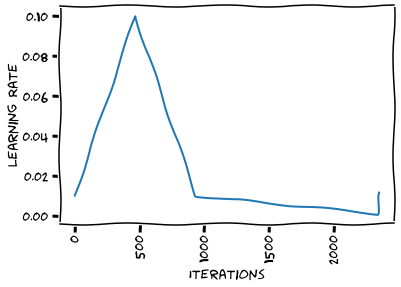

In [16]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=500), rotation=90)
plt.plot(onecycle.lrs[:9276])
plt.savefig('onecycle_lr.jpg')